# Task 1: implementation

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

In [2]:
# Load the data
import sys
import os
sys.path.append('../')
from scripts.helper import *
from scripts.topic_and_event_modeling import *
base_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'Week-0', 'docs', 'data'))
data_df = pd.read_csv(os.path.join(base_path, 'data.csv'))
domains_location_df = pd.read_csv(os.path.join(base_path, 'domains_location.csv'))
traffic_data_df = pd.read_csv(os.path.join(base_path, 'traffic.csv'))
rating_df = pd.read_csv(os.path.join(base_path, 'rating.csv'))


### Clean The data

In [4]:

#Clean the data
data_df = clean_data(data_df)

# Cleaning traffic_data.csv
traffic_custom_types = {
    'GlobalRank': pd.Int64Dtype(),  # Using nullable integer type
    'TldRank': pd.Int64Dtype(),     # Using nullable integer type
    'RefSubNets': pd.Int64Dtype(),  # Using nullable integer type
    'RefIPs': pd.Int64Dtype(),      # Using nullable integer type
    'PrevGlobalRank': pd.Int64Dtype(),  # Using nullable integer type
    'PrevTldRank': pd.Int64Dtype(),     # Using nullable integer type
    'PrevRefSubNets': pd.Int64Dtype(),  # Using nullable integer type
    'PrevRefIPs': pd.Int64Dtype()       # Using nullable integer type
}
traffic_data_df = clean_data(traffic_data_df, custom_types=traffic_custom_types)

# Cleaning rating.csv
rating_date_columns = ['published_at']
rating_custom_types = {
    'article_id': pd.Int64Dtype(),   # Using nullable integer type
    'source_id': pd.Int64Dtype(),    # Using nullable integer type
    'title_sentiment': 'category'
}
rating_df= clean_data(rating_df, date_columns=rating_date_columns, custom_types=rating_custom_types)

# Cleaning domains_location.csv
domains_location_custom_types = {
    'SourceCommonName': 'string',
    'location': 'string',
    'Country': 'string'
}
domains_location_df = clean_data(domains_location_df, custom_types=domains_location_custom_types)

c:\Users\araso\Documents\10academy\Week-0\notebooks\..\scripts\helper.py:245: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
c:\Users\araso\Documents\10academy\Week-0\notebooks\..\scripts\helper.py:245: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
c:\Users\araso\Documents\10academy\Week-0\notebooks\..\scripts\helper.py:245: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
c:\Users\araso\Documents\10academy\Week-0\notebooks\..\scripts\helper.py:245: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


### 1. Websites that have the largest count of news articles

In [5]:

# 1. Websites that have the largest count of news articles
article_counts = data_df['source_name'].value_counts()
top_10_websites_articles = article_counts.head(10)
bottom_10_websites_articles = article_counts.tail(10)

# Display the results
print("Top 10 Websites by Article Count:")
print(top_10_websites_articles)
print("\nBottom 10 Websites by Article Count:")
print(bottom_10_websites_articles)


Top 10 Websites by Article Count:
source_name
ETF Daily News        15039
The Times of India     7062
GlobeNewswire          5127
Forbes                 4233
Biztoc.com             3968
BBC News               3255
Globalsecurity.org     2904
Business Insider       2697
ABC News               2092
Marketscreener.com     1948
Name: count, dtype: int64

Bottom 10 Websites by Article Count:
source_name
Influxdata.com          1
Without.boats           1
Nota-lang.org           1
Koyeb.com               1
UW News                 1
Knowablemagazine.org    1
News.rub.de             1
Robertovitillo.com      1
Signoz.io               1
Omnigroup.com           1
Name: count, dtype: int64


### 2. Websites with the highest numbers of visitors traffic

 ###### Sorting by GlobalRank: Since a lower GlobalRank number represents higher visitor traffic (rank 1 being the highest), we sort the traffic_data_df DataFrame by GlobalRank.

In [6]:
# 2. Websites with the highest numbers of visitors traffic
top_10_websites_traffic = traffic_data_df.sort_values(by='GlobalRank').head(10)[['Domain', 'GlobalRank']]
bottom_10_websites_traffic = traffic_data_df.sort_values(by='GlobalRank').tail(10)[['Domain', 'GlobalRank']]

print("\nTop 10 Websites by Visitor Traffic:")
print(top_10_websites_traffic)
print("\nBottom 10 Websites by Visitor Traffic:")
print(bottom_10_websites_traffic)


Top 10 Websites by Visitor Traffic:
                 Domain  GlobalRank
0            google.com           1
1          facebook.com           2
2           youtube.com           3
3           twitter.com           4
4         instagram.com           5
5          linkedin.com           6
6             apple.com           7
7         microsoft.com           8
8  googletagmanager.com           9
9         wikipedia.org          10

Bottom 10 Websites by Visitor Traffic:
                        Domain  GlobalRank
999990            eiretrip.com      999991
999991    exploring-africa.com      999992
999992                hmag.com      999993
999993          irishcycle.com      999994
999994         keith-baker.com      999995
999995              kireie.com      999996
999996             mt-lock.com      999997
999997           pinkwater.com      999998
999998          soderhomes.com      999999
999999  toyotamusicfactory.com     1000000


### 3. Countries with the highest number of news media organisations (represented by domains in the data)

In [7]:
# 3. Countries with the highest number of news media organisations (represented by domains in the data)
country_domain_counts = domains_location_df['Country'].value_counts()
top_10_countries_domains = country_domain_counts.head(10)
bottom_10_countries_domains = country_domain_counts.tail(10)

print("\nTop 10 Countries by Number of Media Organisations:")
print(top_10_countries_domains)
print("\nBottom 10 Countries by Number of Media Organisations:")
print(bottom_10_countries_domains)


Top 10 Countries by Number of Media Organisations:
Country
United States     14111
United Kingdom     1946
Italy              1804
France             1039
Russia             1020
Canada              886
Germany             884
China               779
Turkey              725
India               686
Name: count, dtype: int64

Bottom 10 Countries by Number of Media Organisations:
Country
Greenland         1
Guernsey          1
Isle of Man       1
Cook Islands      1
Guinea-Bissau     1
Micronesia        1
Aruba             1
American Samoa    1
Guadeloupe        1
Saint Helena      1
Name: count, dtype: int64


### 4. Countries with Many Articles Written About Them

In [8]:

# Example usage:
top_10, bottom_10 = analyze_country_article_counts(data_df, domains_location_df)

print("Top 10 Countries by Article Count:")
print(top_10)

print("\nBottom 10 Countries by Article Count:")
print(bottom_10)


Top 10 Countries by Article Count:
           Country  ArticleCount
56          Israel          3968
10           India          3541
8           Russia          2038
4            China          1723
7    United States          1557
6          Ukraine          1256
18            Iran          1047
54       Australia          1039
99           Niger          1027
101           Oman           990

Bottom 10 Countries by Article Count:
           Country  ArticleCount
101           Oman           990
99           Niger          1027
54       Australia          1039
18            Iran          1047
6          Ukraine          1256
7    United States          1557
4            China          1723
8           Russia          2038
10           India          3541
56          Israel          3968


### 5. Websites that reported about Africa, US, China, EU, Russia, Ukraine, Middle East

In [9]:
# import function from helper.py
# usage:
top_10_regions, bottom_10_regions = analyze_region_article_counts(data_df, domains_location_df)

print("\nTop 10 Regions by Article Count:")
print(top_10_regions)

print("\nBottom 10 Regions by Article Count:")
print(bottom_10_regions)



Top 10 Regions by Article Count:
        Region  ArticleCount
1           US         38021
4       Russia          2038
2        China          1723
5      Ukraine          1256
0       Africa            20
3           EU             2
6  Middle East             2

Bottom 10 Regions by Article Count:
        Region  ArticleCount
3           EU             2
6  Middle East             2
0       Africa            20
5      Ukraine          1256
2        China          1723
4       Russia          2038
1           US         38021


### 6. Websites with the highest count of positive, neutral, and negative sentiment? To do this you will need to group the data by website domain and apply descriptive statistics such as mean, median, and variance

In [10]:

# Example usage:
sentiment_stats, global_sentiment_dist, top_10_domains_sentiment_dist, top_10_sentiment_stats = analyze_sentiment_statistics(rating_df, traffic_data_df)

print("Sentiment Statistics (Mean, Median, Variance) for Each Website Domain:")
print(sentiment_stats.sort_values(by='mean_sentiment', ascending=False))

print("\nComparison of Sentiment Distribution:")
print("Global Sentiment Distribution:")
print(global_sentiment_dist)
print("\nTop 10 Domains Sentiment Distribution:")
print(top_10_domains_sentiment_dist)

print("\nTop 10 Domains by Traffic with Sentiment Statistics:")
print(top_10_sentiment_stats)

c:\Users\araso\Documents\10academy\Week-0\notebooks\..\scripts\helper.py:170: FutureWarning: The provided callable <function mean at 0x0000019B56C7C5E0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  sentiment_stats = rating_df.groupby('source_name')['title_sentiment_numeric'].agg(
c:\Users\araso\Documents\10academy\Week-0\notebooks\..\scripts\helper.py:170: FutureWarning: The provided callable <function median at 0x0000019B74EA3C70> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  sentiment_stats = rating_df.groupby('source_name')['title_sentiment_numeric'].agg(
c:\Users\araso\Documents\10academy\Week-0\notebooks\..\scripts\helper.py:170: FutureWarning: The provided callable <function var at 0x0000019B56C7C820> is currently using Ser

Sentiment Statistics (Mean, Median, Variance) for Each Website Domain:
                     source_name  mean_sentiment  median_sentiment  \
2                Android Central        0.379710               0.0   
9                 Digital Trends        0.367978               0.0   
15                 GlobeNewswire        0.263092               0.0   
12                        Forbes        0.156089               0.0   
25                     The Verge        0.099174               0.0   
21                     ReadWrite        0.086066               0.0   
17            Marketscreener.com        0.081498               0.0   
10                ETF Daily News        0.043919               0.0   
24            The Times of India       -0.001357               0.0   
8                       Deadline       -0.020725               0.0   
6                            CNA       -0.059347               0.0   
13                   Gizmodo.com       -0.076305               0.0   
22            The I

### 7. Similarity of Raw Message Lengths Across Sites and How similar are the number of words in the title across sites? Check the distribution among sites

c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6044 (\N{KHMER LETTER VO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6072 (\N{KHMER VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6050 (\N{KHMER LETTER QA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6076 (\N{KHMER VOWEL SIGN UU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 

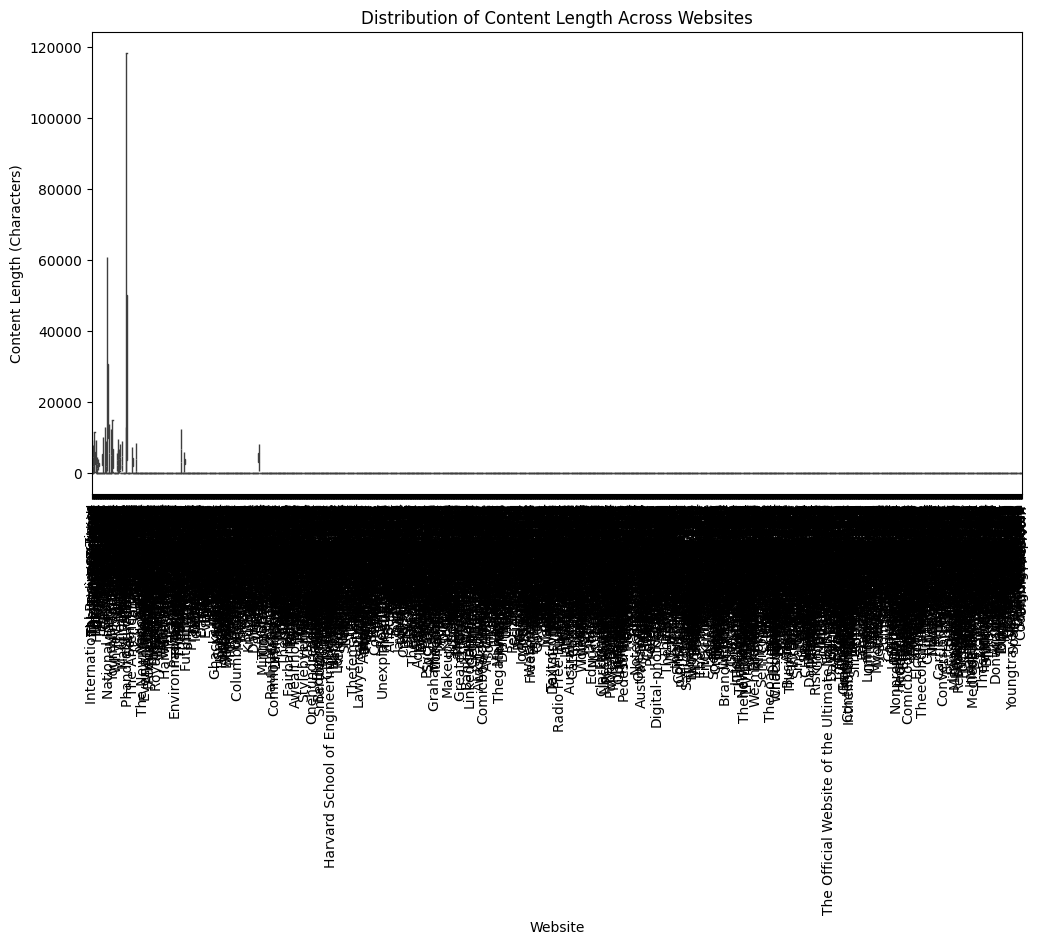

c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6044 (\N{KHMER LETTER VO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6072 (\N{KHMER VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6050 (\N{KHMER LETTER QA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6076 (\N{KHMER VOWEL SIGN UU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\araso\Documents\10academy\Week-0\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 

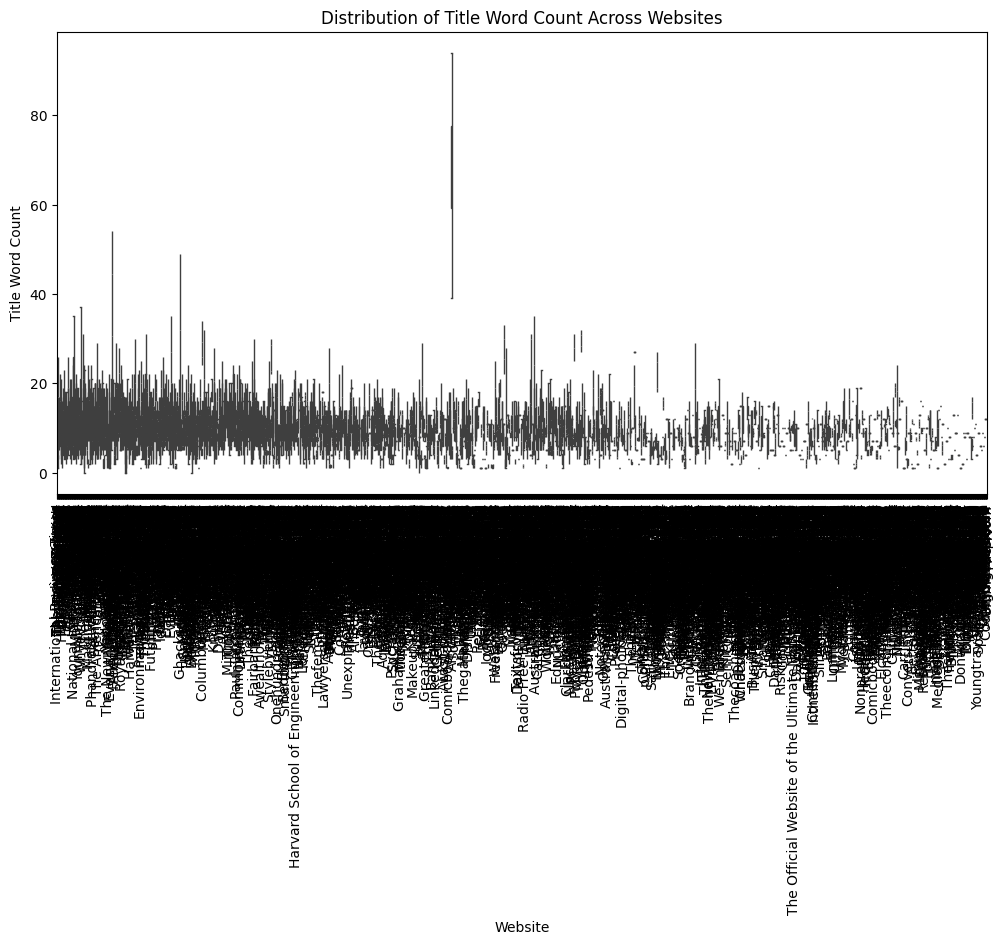

Descriptive Statistics of Content Length Across Sites:
                        count  mean  std  min  25%  50%  75%  max
source_name                                                      
/FILM                   142.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1000wordphilosophy.com    1.0   0.0  NaN  0.0  0.0  0.0  0.0  0.0
100daysofrealfood.com     9.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
100layercake.com          2.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
101cookbooks.com         10.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
...                       ...   ...  ...  ...  ...  ...  ...  ...
thechalkboardmag.com      2.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
thereformedbroker.com     3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
tomandlorenzo.com        10.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
tor.com                  18.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
វីអូអេ - VOA Khmer        6.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

[2379 rows x 8 columns]

Descriptive Statistics of Title Word Count Across Sites:
    

In [11]:

# Similarity of Raw Message Lengths Across Sites
# Calculate the length of the full content for each article
data_df['content_length'] = data_df['full_content'].apply(lambda x: len(x) if x else 0)

# Group by source_name to compare distributions
content_length_distribution = data_df.groupby('source_name')['content_length'].describe()

# Plot the distribution of content length for top websites
plt.figure(figsize=(12, 6))
sns.boxplot(x='source_name', y='content_length', data=data_df, showfliers=False)
plt.title('Distribution of Content Length Across Websites')
plt.xlabel('Website')
plt.ylabel('Content Length (Characters)')
plt.xticks(rotation=90)
plt.show()

# Similarity of the Number of Words in the Title Across Sites
# Calculate the number of words in the title for each article
data_df['title_word_count'] = data_df['title'].apply(lambda x: len(x.split()) if x else 0)

# Group by source_name to compare distributions
title_word_count_distribution = data_df.groupby('source_name')['title_word_count'].describe()

# Plot the distribution of title word count for top websites
plt.figure(figsize=(12, 6))
sns.boxplot(x='source_name', y='title_word_count', data=data_df, showfliers=False)
plt.title('Distribution of Title Word Count Across Websites')
plt.xlabel('Website')
plt.ylabel('Title Word Count')
plt.xticks(rotation=90)
plt.show()

# Display descriptive statistics for both analyses
print("Descriptive Statistics of Content Length Across Sites:")
print(content_length_distribution)

print("\nDescriptive Statistics of Title Word Count Across Sites:")
print(title_word_count_distribution)


### 8. Do a 2D scatter plot where x-axis is the total number of reports by a website, y-axis is the global ranking of the site, and the color representing average/median sentiment. 

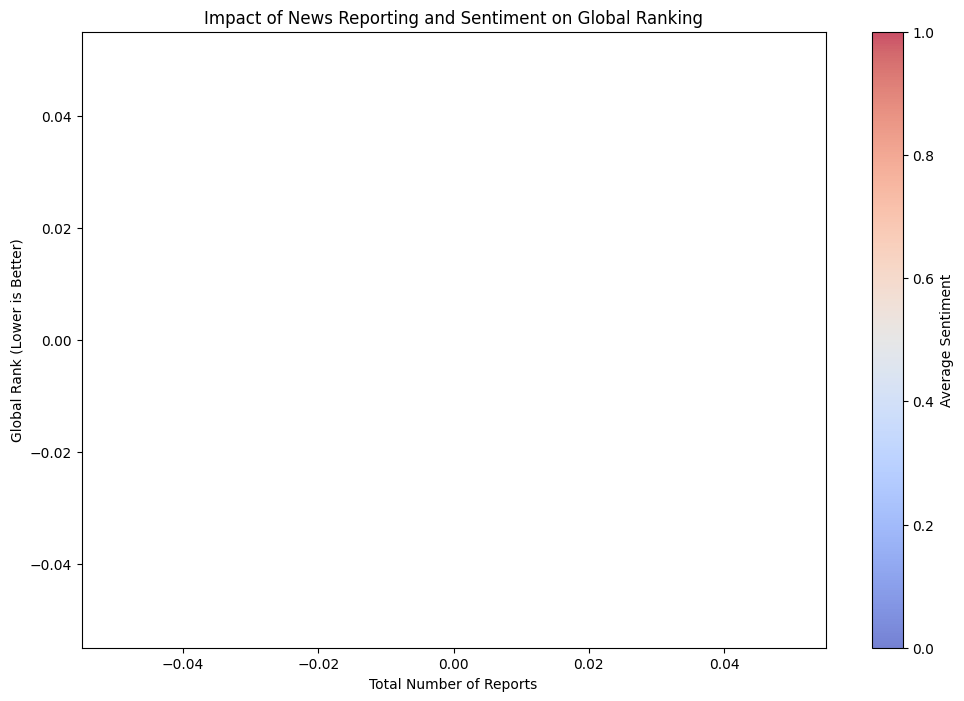

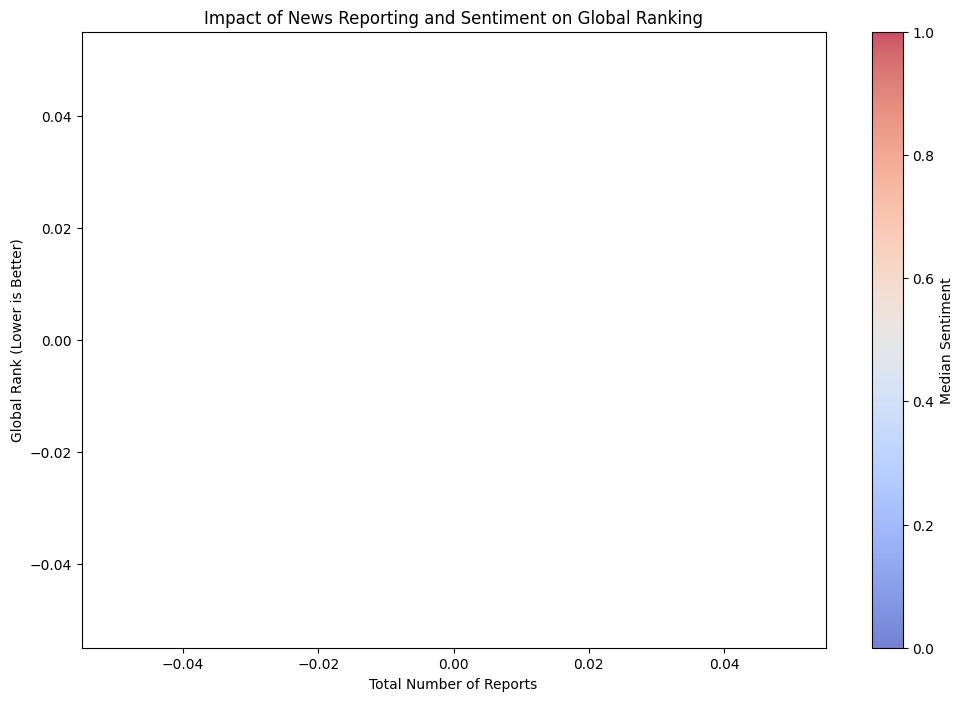

In [12]:
# Calculate the total number of reports by each website
report_counts = rating_df.groupby('source_name').size().reset_index(name='total_reports') # type: ignore

# Calculate the average and median sentiment for each website
sentiment_agg = rating_df.groupby('source_name')['title_sentiment_numeric'].agg(
    avg_sentiment='mean',
    median_sentiment='median'
).reset_index()

# Merge with traffic data to get the global ranking
merged_data = pd.merge(report_counts, sentiment_agg, on='source_name')
merged_data = pd.merge(merged_data, traffic_data_df[['Domain', 'GlobalRank']], left_on='source_name', right_on='Domain')

# Plot the 2D scatter plot with average sentiment
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=merged_data['total_reports'],
    y=merged_data['GlobalRank'],
    c=merged_data['avg_s-entiment'],
    cmap='coolwarm',
    s=100,
    alpha=0.7
)
plt.colorbar(scatter, label='Average Sentiment')
plt.xlabel('Total Number of Reports')
plt.ylabel('Global Rank (Lower is Better)')
plt.title('Impact of News Reporting and Sentiment on Global Ranking')
plt.show()

# Plot the 2D scatter plot with median sentiment
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    x=merged_data['total_reports'],
    y=merged_data['GlobalRank'],
    c=merged_data['median_sentiment'],
    cmap='coolwarm',
    s=100,
    alpha=0.7
)
plt.colorbar(scatter, label='Median Sentiment')
plt.xlabel('Total Number of Reports')
plt.ylabel('Global Rank (Lower is Better)')
plt.title('Impact of News Reporting and Sentiment on Global Ranking')
plt.show()

# Task 2: Implementation

### 1. Perform Keyword extraction/modelling using TF-IDF

In [13]:

# Extract keywords for titles and full content
data_df['title_keywords'] = extract_keywords_tfidf(data_df['title'], n=5)
data_df['content_keywords'] = extract_keywords_tfidf(data_df['full_content'], n=5)

# Calculate similarity between title and content keywords across sites
data_df['keyword_similarity'] = data_df.apply(lambda row: calculate_similarity(row['title_keywords'], row['content_keywords']), axis=1)

# Analyze similarity by site
similarity_by_site = data_df.groupby('source_name')['keyword_similarity'].mean().reset_index()

# Display the results
print("Similarity of Keywords in Titles and Content Across Sites:")
print(similarity_by_site.sort_values(by='keyword_similarity', ascending=False))


Similarity of Keywords in Titles and Content Across Sites:
             source_name  keyword_similarity
103      Android Central            0.228419
540       Digital Trends            0.205971
1531            Phys.Org            0.189183
1624           ReadWrite            0.186285
809        GlobeNewswire            0.173600
...                  ...                 ...
806          Global News            0.000000
807    Globalresearch.ca            0.000000
810    Glyphdrawing.club            0.000000
811            Gnome.org            0.000000
2378  វីអូអេ - VOA Khmer            0.000000

[2379 rows x 2 columns]


### 2. Perform topic modelling.

#### 2.1 categorise the title/content into a known set of topic categories

In [15]:

# Perform topic modeling
n_topics = 10  # Number of topics to identify
lda, topics, vectorizer = perform_topic_modeling_by_lda(data_df, n_topics=n_topics)

# Assign the most likely topic to each article
topic_assignments = lda.transform(vectorizer.transform(data_df['text'])).argmax(axis=1)
data_df['topic'] = topic_assignments


#### 2.2 Which websites reported the most diverse topics?

In [16]:

# Analyze topic diversity
most_diverse_sites = analyze_topic_diversity(data_df)
print("Websites Reporting the Most Diverse Topics:")
print(most_diverse_sites.head(10))


Websites Reporting the Most Diverse Topics:
                       source_name  unique_topics
1276      Minneapolis Star Tribune             10
1007                      Jalopnik             10
131                      ArchDaily             10
809                  GlobeNewswire             10
121                   AppleInsider             10
970   International Business Times             10
579                           ESPN             10
976                  Investing.com             10
980              InvestorsObserver             10
1218                   MarketWatch             10


#### 2.3 Analyse the topic trends. 

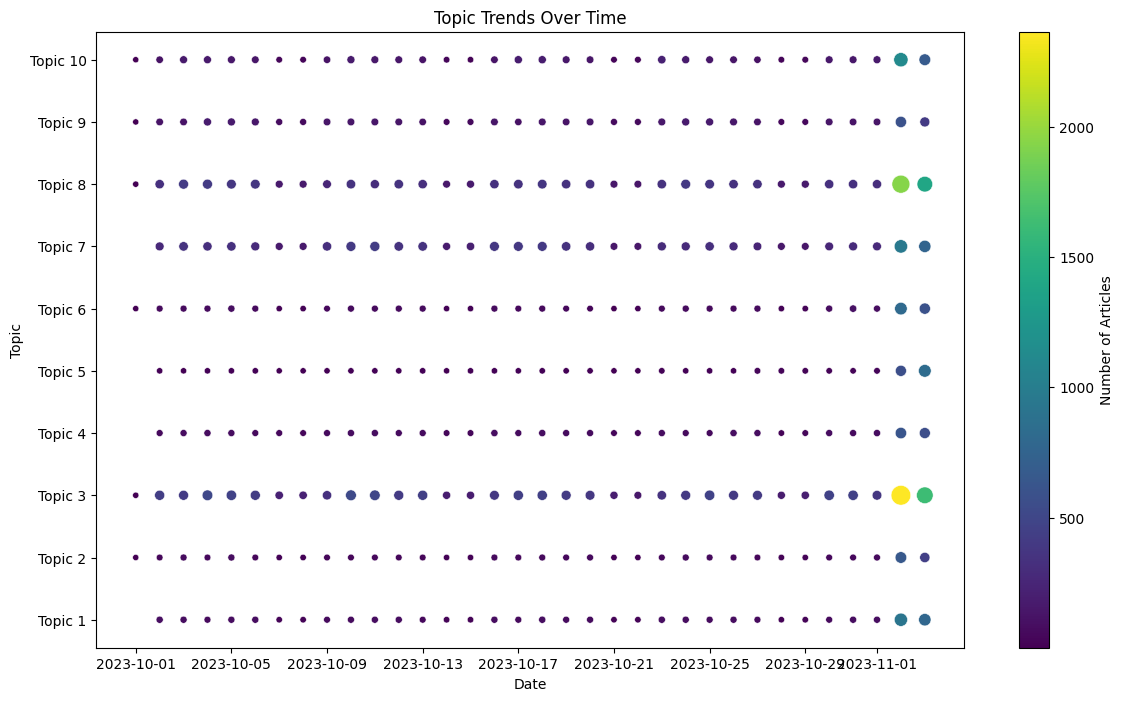

In [17]:

def plot_topic_trends(df, n_topics):
    # Group by date and topic, then count the occurrences
    trend_data = df.groupby([df['published_at'].dt.date, 'topic']).size().reset_index(name='count')
    
    # Plot the trends
    plt.figure(figsize=(14, 8))
    ax = plt.gca()  # Get the current axis
    scatter = sns.scatterplot(data=trend_data, x='published_at', y='topic', size='count', hue='count', palette='viridis', sizes=(20, 200), legend=False, ax=ax)

    # Manually create the colorbar
    norm = plt.Normalize(trend_data['count'].min(), trend_data['count'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    
    # Add the colorbar to the correct axis
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Number of Articles')
    
    plt.title('Topic Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Topic')
    plt.yticks(range(n_topics), labels=[f'Topic {i+1}' for i in range(n_topics)])
    plt.show()

# Plot topic trends
plot_topic_trends(data_df, n_topics=n_topics)



### 3. Model the events that the news articles are written about

In [21]:

data_df['text'] = data_df['title'] + " " + data_df['full_content']

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english', max_features=10000)
tfidf_matrix = vectorizer.fit_transform(data_df['text'])

# Apply K-Means clustering to group articles into events
num_clusters = 10  # Adjust the number of clusters based on the dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
data_df['event_cluster'] = kmeans.labels_

# 1. How many events are covered in the data?
num_events = data_df['event_cluster'].nunique()
print(f"Number of events covered in the data: {num_events}")

# 2. Which news sites report events the earliest?
data_df['published_at'] = pd.to_datetime(data_df['published_at'], errors='coerce')
data_df = data_df.dropna(subset=['event_cluster', 'published_at', 'source_name'])
earliest_reports = data_df.groupby(['event_cluster', 'source_name'])['published_at'].min().reset_index()
earliest_site_per_event = earliest_reports.loc[earliest_reports.groupby('event_cluster')['published_at'].idxmin()]
print("Earliest reporting news sites per event:")
print(earliest_site_per_event)

# 3. Which events have the highest reporting?
event_reporting = data_df['event_cluster'].value_counts().reset_index()
event_reporting.columns = ['event_cluster', 'num_articles']
print("Events with the highest reporting:")
print(event_reporting.head(10))

# 4. Correlation between news sites reporting events
# Create a pivot table to count the number of reports per site per event
pivot_table = pd.pivot_table(data_df, index='event_cluster', columns='source_name', aggfunc='size', fill_value=0)

# Calculate the correlation between news sites based on events they report
correlation_matrix = pivot_table.corr()
print("Correlation matrix between news sites reporting events:")
print(correlation_matrix)


Number of events covered in the data: 10
Earliest reporting news sites per event:
      event_cluster         source_name        published_at
115               0     Order-order.com 2023-10-02 08:42:48
176               1           The Punch 2023-10-22 23:53:14
177               2      ETF Daily News 2023-11-03 14:24:54
332               4                Time 2023-10-02 09:00:00
351               6            BBC News 2023-10-02 14:13:05
482               7     Android Central 2023-10-01 20:00:46
2740              8  Marketscreener.com 2023-10-12 16:10:06
Events with the highest reporting:
   event_cluster  num_articles
0              7         60040
1              8          1119
2              0           844
3              4           817
4              6           110
5              1             1
6              2             1
Correlation matrix between news sites reporting events:
source_name                /FILM  1000wordphilosophy.com  \
source_name                            

### 4. Version your ML models and their artefacts using MLFlow

#### 4.1 Train and Log the Topic Modeling Model

In [ ]:
# To extract relevant feature to store to database and to prepare ML parameters

def vectorize_text(df):
    # Use TF-IDF to vectorize the text data
    vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english', max_features=10000)
    tfidf_matrix = vectorizer.fit_transform(df['text'])
    return tfidf_matrix, vectorizer

# Vectorize the text data
tfidf_matrix, vectorizer = vectorize_text(data_df)

def cluster_texts(tfidf_matrix, num_clusters=10):
    # Apply K-Means clustering
    km = KMeans(n_clusters=num_clusters, random_state=42)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    return km, clusters

# Determine the number of clusters (this could be optimized based on your data)
num_clusters = 10

# Perform clustering
kmeans_model, clusters = cluster_texts(tfidf_matrix, num_clusters)
data_df['cluster'] = clusters

def get_top_keywords(cluster_centers, vectorizer, top_n=10):
    keywords = []
    for i, cluster_center in enumerate(cluster_centers):
        top_indices = cluster_center.argsort()[-top_n:]
        top_keywords = [vectorizer.get_feature_names_out()[index] for index in top_indices]
        keywords.append(top_keywords)
    return keywords

# Get top keywords for each cluster
top_keywords = get_top_keywords(kmeans_model.cluster_centers_, vectorizer, top_n=10)

# Assign event descriptions based on top keywords
data_df['event_description'] = data_df['cluster'].apply(lambda x: ', '.join(top_keywords[x]))

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(tfidf_matrix)
topics = get_top_keywords(lda.components_, vectorizer, top_n=10)

data_df['topic_keywords'] = data_df.index.map(lambda x: ', '.join(topics[x % len(topics)]))


In [28]:
import mlflow
import mlflow.sklearn
from sklearn.decomposition import LatentDirichletAllocation

# Set the MLFlow tracking URI
# mlflow.set_tracking_uri("http://localhost:5000")  # Change this if you're using a different tracking server
# mlflow.set_experiment("News_Article_Models")

# Assuming tfidf_matrix is already prepared

with mlflow.start_run(run_name="LDA_Topic_Modeling"):
    # Train the LDA model
    lda = LatentDirichletAllocation(n_components=10, random_state=42)
    lda.fit(tfidf_matrix)
    
    # Log parameters and metrics (example: log the number of components)
    mlflow.log_param("n_components", 10)
    
    # Log the LDA model
    mlflow.sklearn.log_model(lda, "LDA_model")
    
    # Optionally log the topics discovered by the model
    topics = get_top_keywords(lda.components_, vectorizer, top_n=10)
    for i, topic in enumerate(topics):
        mlflow.log_text(f"Topic {i+1}: {', '.join(topic)}", f"topic_{i+1}.txt")
    
    print("LDA model and topics logged in MLFlow.")


2024/08/30 22:50:03 INFO mlflow.tracking.fluent: Experiment with name 'News_Article_Models' does not exist. Creating a new experiment.


MlflowException: API request to http://localhost:5000/api/2.0/mlflow/runs/get failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/get?run_uuid=d4710c23a0e34cbc9dde4f7ad71002ef&run_id=d4710c23a0e34cbc9dde4f7ad71002ef (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001D75F394AC0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

#### 4.2 Train and Log the Event Modeling Model

In [ ]:

# Assuming tfidf_matrix and other necessary data are prepared
with mlflow.start_run(run_name="KMeans_Event_Clustering"):
    # Train the K-Means model
    num_clusters = 10
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    
    # Log parameters
    mlflow.log_param("n_clusters", num_clusters)
    
    # Log the K-Means model
    mlflow.sklearn.log_model(kmeans, "KMeans_model")
    
    # Log the cluster centers or other relevant artifacts
    for i, center in enumerate(kmeans.cluster_centers_):
        mlflow.log_text(f"Cluster {i+1} center: {center}", f"cluster_{i+1}_center.txt")
    
    print("K-Means model and cluster centers logged in MLFlow.")


## Task 3: Database Summary


#### Table Schema: I designed a schema to store the articles, topics, events, and features.
#### Schema Visualization: The schema was visualized using dbdiagram.io.
#### Creating Tables: I used SQLAlchemy to define and create the tables in PostgreSQL.
#### Loading Data: Finally, I loaded the relevant data into the PostgreSQL tables.

In [3]:
import sys
sys.path.append('../')

from src.db.models import *
from src.db.db_config import *

Base.metadata.create_all(bind=engine)
print(topics)
print(data_df.iterrows())
# Function to load data into the database

def load_data(data_df, tfidf_matrix, topics):
    session = SessionLocal()
    
    # Ensure the data frame index aligns with the tfidf_matrix row indices
    data_df.reset_index(drop=True, inplace=True)
    
    # Convert data to dictionaries for insertion
    articles_data = data_df[['article_id', 'source_name', 'published_at', 'title', 'full_content']].to_dict(orient='records')
    
    # Create topics and events data with safe indexing
    topics_data = [{'topic_keywords': ', '.join(topics[row['cluster'] % len(topics)]), 'article_id': row['article_id']} for index, row in data_df.iterrows()]
    events_data = [{'event_description': row['event_description'], 'article_id': row['article_id']} for index, row in data_df.iterrows()]
    
    # Extract the TF-IDF vectors and convert them to a string format to store in the database
    features_data = [{'article_id': row['article_id'], 'tfidf_vector': str(tfidf_matrix[index].toarray().flatten()), 'topic': row['cluster'], 'event_cluster': row['cluster']} for index, row in data_df.iterrows()]
#
    try:
        # Insert data into tables
        session.bulk_insert_mappings(Article, articles_data)
        session.bulk_insert_mappings(Topic, topics_data)
        session.bulk_insert_mappings(Event, events_data)
        session.bulk_insert_mappings(Feature, features_data)
        session.commit()
        print("Insertion Done!!!")
    except Exception as e:
        session.rollback()  # Rollback the transaction if any exception occurs
        print(f"An error occurred: {e}")
    finally:
        session.close()

# Example usage
load_data(data_df, tfidf_matrix, topics)

NameError: name 'topics' is not defined